In [2]:
import pandas as pd
import requests
import datetime
import json
import lxml

## Pulling the Crossword Data from 1976 - 2015

In [3]:
list_of_dates = list(pd.date_range(start='1/5/1976', end='12/31/2015'))

In [4]:
def get_crossword_data(date):
    try:
        f = open(f'nyt_crosswords-master/{date.year}/{date.month:02}/{date.day:02}.json','r')
        data = json.loads(f.read())
        filled_letters = data['answers']['across']
        length = sum(len(s) for s in filled_letters)
        answers = data['answers']['across'] + data['answers']['down']
        clues = data['clues']['across'] + data['clues']['down']
        author = data['author'] 
        cols = data['size']['cols']
        rows = data['size']['rows']
        editor = data['editor']
        return pd.Series({'answers': answers, 'clues': clues, 'editor':editor, 'author': author, 'size' : rows * cols, 'length' : length})
    except:
        return pd.Series({'answers': [], 'clues': [], 'editor':'', 'author': '', 'size' : 0, 'length' : 0})


In [5]:
df = pd.DataFrame({
    'crossword_date': list_of_dates
})

results = df.crossword_date.apply(get_crossword_data)
df = df.join(results)

df['density'] = df['length']/df['size']
df

,crossword_date,answers,clues,editor,author,size,length,density
0,1976-01-05,"[AJAX, WHOOP, CRAB, BALI, HEAVE, HAME, ADMIRAL...","[1. Greek hero, 5. Loud cry, 10. Peevish perso...",Will Weng,Herb L. Risteen,225,187,0.831111
1,1976-01-06,"[ACTS, GRAB, SHAM, BEAT, GRETA, TONE, ABRA, LA...","[1. Bible book, 5. Seize, 9. Counterfeit, 13. ...",Will Weng,DeWitt Anderson,225,187,0.831111
2,1976-01-07,"[ITA, TILO, CACHE, SNOB, ODOR, ATHOS, OARS, GO...","[1. Give ___ whirl, 4. Linden tree, in Spain, ...",Will Weng,Miller,225,187,0.831111
3,1976-01-08,"[BOMA, ACME, LIEGE, ORES, COATHANGER, WISHFULT...","[1. African stockade, 5. Utmost degree, 9. Feu...",Will Weng,Frank Geary,225,189,0.840000
4,1976-01-09,"[PROS, ARC, FBI, POLES, PULP, IRON, STERE, SEA...","[1. Golf-tour players, 5. Curve part, 8. Govt....",Will Weng,Brian G. Tyler,225,179,0.795556
...,...,...,...,...,...,...,...,...
14601,2015-12-27,[],[],,,0,0,NaN
14602,2015-12-28,[],[],,,0,0,NaN
14603,2015-12-29,[],[],,,0,0,NaN
14604,2015-12-30,[],[],,,0,0,NaN


In [10]:
df = df.dropna()
df_answers_clues = df.set_index('crossword_date').apply(pd.Series.explode).reset_index()
#sparse_array
df_answers_clues[['code','clues']] = df_answers_clues['clues'].str.split(".", 1, expand=True)
df_answers_clues['day_of_week'] = df_answers_clues.crossword_date.dt.day_name()
df_answers_clues['answer_length'] = df_answers_clues['answers'].str.len()
df_answers_clues['crossword_year'] = df_answers_clues['crossword_date'].dt.year
df_answers_clues

,crossword_date,answers,clues,editor,author,size,length,density,code,day_of_week,answer_length,crossword_year
0,1976-01-05,AJAX,Greek hero,Will Weng,Herb L. Risteen,225,187,0.831111,1,Monday,4,1976
1,1976-01-05,WHOOP,Loud cry,Will Weng,Herb L. Risteen,225,187,0.831111,5,Monday,5,1976
2,1976-01-05,CRAB,Peevish person,Will Weng,Herb L. Risteen,225,187,0.831111,10,Monday,4,1976
3,1976-01-05,BALI,Romantic isle,Will Weng,Herb L. Risteen,225,187,0.831111,14,Monday,4,1976
4,1976-01-05,HEAVE,Lift,Will Weng,Herb L. Risteen,225,187,0.831111,15,Monday,5,1976
...,...,...,...,...,...,...,...,...,...,...,...,...
1214415,2015-08-29,EVA,"""Little"" girl of fiction",Will Shortz,Evan Birnholz,225,194,0.862222,43,Saturday,3,2015
1214416,2015-08-29,SQUIB,News filler,Will Shortz,Evan Birnholz,225,194,0.862222,47,Saturday,5,2015
1214417,2015-08-29,SALE,Good time to get the goods,Will Shortz,Evan Birnholz,225,194,0.862222,50,Saturday,4,2015
1214418,2015-08-29,USES,Milks,Will Shortz,Evan Birnholz,225,194,0.862222,51,Saturday,4,2015


<b> df_answers_clues is the cleaned up dataframe that contains all the Crossword details </b>

## <b>Day of the Week Analysis: What makes a crossword difficult?</b>
<i>Crosswords are supposed to get more difficult as the week progresses: Monday = easiest -> Saturday = more difficult, Sunday is the biggest puzzle but midweek difficulty. </i>

In [16]:
dayOrder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

<b> Density: </b> The ratio of black square to white squares <br/> The density of the puzzle seem to be consistent across the days of the week

In [13]:
Pivotdf = pd.pivot_table(df_answers_clues,
                        values=['density'],
                        columns=['day_of_week'],
#                         fill_value=0,
                        aggfunc='mean').reindex(dayOrder,axis=1)
Pivotdf

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
density,0.831023,0.832434,0.834013,0.840442,0.849042,0.852642,0.833247


<b> Grid Size: </b> The size of the puzzles are the same every day except Sunday, for which day, the grid size is variable

In [14]:
GridSize_df = pd.pivot_table(df_answers_clues,
                        values=['size'],
                        columns=['day_of_week'],
                        fill_value=0,
                        aggfunc='describe')
GridSize_df

day_of_week         Friday         Monday       Saturday         Sunday  \
size 25%        225.000000     225.000000     225.000000     441.000000   
     50%        225.000000     225.000000     225.000000     441.000000   
     75%        225.000000     225.000000     225.000000     441.000000   
     count   147041.000000  157534.000000  146233.000000  295950.000000   
     max        240.000000     240.000000     289.000000     729.000000   
     mean       225.072939     225.012873     225.103096     459.980622   
     min        225.000000     210.000000     169.000000     420.000000   
     std          1.043441       1.064893       2.307869      37.669837   

day_of_week       Thursday        Tuesday      Wednesday  
size 25%        225.000000     225.000000     225.000000  
     50%        225.000000     225.000000     225.000000  
     75%        225.000000     225.000000     225.000000  
     count   153849.000000  157325.000000  156488.000000  
     max        256.000000     240.000000     240.000000  
     mean       225.236927     225.119714     225.113089  
     min        196.000000     210.000000     210.000000  
     std          2.251013       1.423847       1.378930

<b> Word Length: </b> What is the average length of the words <br/> Longest words are found in the Sunday paper 


<AxesSubplot:>

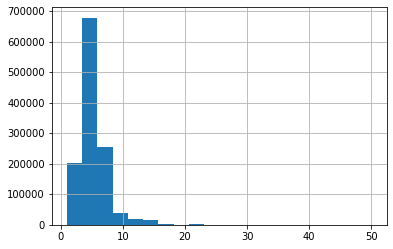

In [17]:
df_answers_clues.answer_length.hist(bins = 20)

In [18]:
df_answers_clues[df_answers_clues.answer_length > 15].sort_values('answer_length', ascending = False)['day_of_week'].value_counts()

Sunday       3209
Thursday      107
Friday         25
Saturday       18
Tuesday        17
Wednesday      13
Monday          7
Name: day_of_week, dtype: int64

In [20]:
df_answers_clues.groupby(['day_of_week']).describe().answer_length

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,147041.0,5.326324,2.273716,3.0,4.0,5.0,6.0,28.0
Monday,157534.0,4.866695,2.000655,3.0,4.0,4.0,5.0,24.0
Saturday,146233.0,5.389085,2.199345,2.0,4.0,5.0,6.0,26.0
Sunday,295950.0,5.265362,2.470678,2.0,4.0,5.0,6.0,50.0
Thursday,153849.0,5.039019,2.121459,1.0,4.0,4.0,6.0,35.0
Tuesday,157325.0,4.888543,2.028625,3.0,4.0,4.0,5.0,17.0
Wednesday,156488.0,4.921643,2.059933,2.0,4.0,4.0,5.0,19.0


<b> Unique Words: </b> Words in the crossword frequently repeat. But which days have the more number of unique answers - the answers that don't show up anywhere else



In [21]:
unique_words = df_answers_clues[df_answers_clues['answers'].map(df_answers_clues['answers'].value_counts()) == 1]
unique_words.groupby('day_of_week').count()

pd.pivot_table(unique_words,
                values=['answers'],
                columns=['day_of_week'],
                fill_value=0,
                aggfunc='count').reindex(dayOrder,axis=1)


day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
answers,5063,6074,7154,8252,9442,10679,23256


#### Looking through the Answers

In [22]:
df_answers_clues.groupby(["answer_length", "answers"])["answers"].value_counts(ascending=False).groupby(level=0, group_keys=False).nlargest(1).to_frame()

,,,answers
answer_length,answers,answers,
1,T,T,1
2,PI,PI,2
3,ERA,ERA,868
4,AREA,AREA,889
5,ERASE,ERASE,516
6,ESTATE,ESTATE,164
7,ESTATES,ESTATES,79
8,ONEONONE,ONEONONE,36
9,ARISTOTLE,ARISTOTLE,20


In [23]:
df_answers_clues['answers'].value_counts().head(5)


AREA    889
ERA     868
ERIE    810
ERE     743
ALOE    719
Name: answers, dtype: int64

## Trends over time (years)

<b> A question mark usually signifies the clue is a pun or uses the meanings of the clue words in some unexpected way. </b>

<AxesSubplot:>

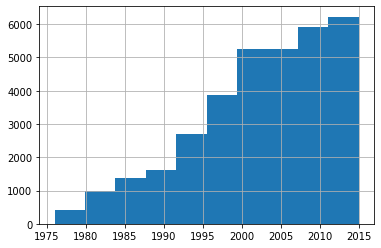

In [45]:
df_answers_clues[df_answers_clues['clues'].str.contains("?", regex=False) == True]
df_answers_clues[df_answers_clues['clues'].str.contains("?", regex=False) == True].crossword_year.hist()


<b> Culturally specific terms that have been popularized in the mainstream </b>


In [35]:
# df_answers_clues[df_answers_clues['answers'].str.contains('YOGA', regex=False) == True]
# df_answers_clues[df_answers_clues['answers'].str.contains('TACOS', regex=False) == True]
df_answers_clues[df_answers_clues['answers'].str.contains('GUAC', regex=False) == True]


,crossword_date,answers,clues,editor,author,size,length,density,code,day_of_week,answer_length,crossword_year
533307,1993-04-23,GUACAMOLE,Mexican dip,Eugene T. Maleska,Eugene T. Maleska,225,191,0.848889,61,Friday,9,1993
544182,1993-09-03,GUACO,Plant used as an antidote for snakebites,Eugene T. Maleska,Eugene T. Maleska,225,193,0.857778,32,Friday,5,1993
1009300,2008-11-26,HOLYGUACAMOLE,"""Zounds!""",Will Shortz,Harvey Estes,225,189,0.840000,20,Wednesday,13,2008
1059447,2010-07-22,GUACAMOLE,Salsa partner?,Will Shortz,Jeremy Horwitz,225,186,0.826667,17,Thursday,9,2010
1091695,2011-08-11,GUAC,"Some chip dip, informally",Will Shortz,Parker Lewis,225,191,0.848889,28,Thursday,4,2011
1123230,2012-08-25,GUAC,Tex-Mex topping,Will Shortz,Caleb Madison,225,190,0.844444,22,Saturday,4,2012
1140775,2013-03-25,GUACAMOLE,Super Bowl bowlful,Will Shortz,Adam Prince,225,187,0.831111,33,Monday,9,2013
1185503,2014-09-14,GUAC,"Some chip dip, informally",Will Shortz,Tony Orbach and Patrick Blindauer,441,373,0.845805,68,Sunday,4,2014
1196031,2015-01-19,GUAC,"Green dip, for short",Will Shortz,Jean O&#39;Conor,225,187,0.831111,49,Monday,4,2015


<b> Crosswords have themes and the answers that relate to one another in the puzzle have an asterix in the clue</b><br/>
I noticed that there were several clues referencing the TV show M*A*SH - removed those to see the trend in the number of thematic puzzles

<AxesSubplot:>

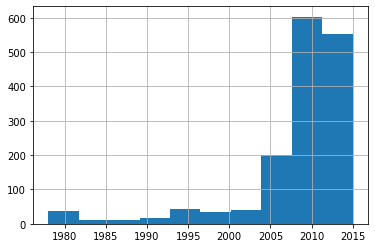

In [47]:
non_MASH = df_answers_clues[df_answers_clues['clues'].str.contains("M*A*S*H", regex=False) == False]
non_MASH[non_MASH['clues'].str.contains("*", regex=False) == True].crossword_year.hist()

<b>How are girls described</b><br/> What are phrases that caricatures women names

In [53]:
df_answers_clues[df_answers_clues['clues'].str.contains('girl') & df_answers_clues['clues'].str.contains('?', regex=False)][['answers', 'clues']].head(30)

,answers,clues
26459,WHATSA,"""___ nice girl like you doing . . . ?"""
205657,NELL,Curious girl?
213225,DATED,Like a popular girl?
218251,AMAZON,Super girl?
240024,MINI,Skirt length for Mickey's girlfriend?
252122,WITHGOODGRACE,"Escorting a nice ""country girl""?"
252193,SADIE,Rainy-day girl?
299075,IRENE,Shalom girl?
314129,ELIZATOOLITTLE,Undersized flower girl?
351104,EMMY,Oscar's girlfriend?


<b>Slang terms in the XWord</b><br/> Clues often contain 'colloquially', modern lingo, 'slang', 'informally', 'slangily'

In [54]:
slang = df_answers_clues[df_answers_clues['clues'].str.contains('colloquially', regex=False) |df_answers_clues['clues'].str.contains('modern lingo', regex=False) | df_answers_clues['clues'].str.contains('slang', regex=False) | df_answers_clues['clues'].str.contains('informally', regex=False) | df_answers_clues['clues'].str.contains('informally', regex=False)]
slang.answers.drop_duplicates()
#AMMO, RAP, PICS

40042         LEGGO
69532        LIBBER
72384         SCHMO
73995          OKAY
90685          SWAP
             ...   
1213454      UNPLUG
1213839        JACK
1214094      CHROMO
1214227    UTDALLAS
1214408     WEIRDAL
Name: answers, Length: 1619, dtype: object

<AxesSubplot:>

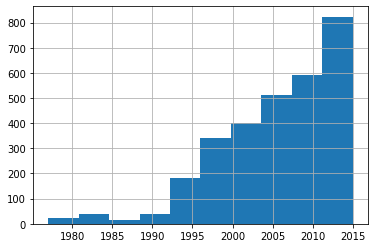

In [55]:
df_answers_clues[df_answers_clues['clues'].str.contains('colloquially', regex=False) |df_answers_clues['clues'].str.contains('modern lingo', regex=False) | df_answers_clues['clues'].str.contains('slang', regex=False) | df_answers_clues['clues'].str.contains('informally', regex=False) | df_answers_clues['clues'].str.contains('slangily', regex=False)]['crossword_year'].hist()

<b>The following block was a playground where I just placed random words in the 'contains' section to see what kind of answers showed up <b/>

In [178]:
df_answers_clues[df_answers_clues['clues'].str.contains('emoji', regex=False)].tail(50)

,crossword_date,answers,clues,editor,author,size,length,density,code,day_of_week,answer_length,crossword_year
1178484,2014-06-22,TEXT,"Message with an emoji, maybe",Will Shortz,Elizabeth C. Gorski,441,370,0.839002,18,Sunday,4,2014
1217807,2016-07-12,TEXT,It might contain an emoji,Will Shortz,Samuel A. Donaldson,225,191,0.848889,13,Tuesday,4,2016


In [56]:
df_answers_clues[df_answers_clues['clues'].str.contains('!', regex=False) == True][['answers', 'clues']].drop_duplicates()

,answers,clues
515,ATTA,"""___ boy!"""
823,DEARME,Alas!
1019,MAIS,"""___ oui!"""
1106,HATH,"""What ___ God wrought!"""
1136,RATS,Zounds!
...,...,...
1213929,MERCYME,"""Heavens!"""
1213994,AMI,"""What a good boy ___!"": Little Jack Horner"
1214039,EAT,"""Let's ___!"" (words after saying grace)"
1214057,OHFOO,"Granny's ""Darn it!"""


In [58]:
# REUP, GMAN
# OVER TIME: ALLERGY, BAGS, 
# person represents another meaning: ABES:FIVER, BAILS. 
frequent_answers= df_answers_clues[df_answers_clues['answers'] == 'BAILS']
unique_clues = frequent_answers[['answers','clues','crossword_year']].sort_values(['crossword_year']).drop_duplicates()
unique_clues.head(50)

,answers,clues,crossword_year
54039,BAILS,Removes water,1977
150753,BAILS,___ out (parachutes),1981
162751,BAILS,"Uses a parachute, with ""out""",1981
224131,BAILS,Buccaneers' buckets,1983
299738,BAILS,Scoops up water in a boat,1985
364843,BAILS,Scoops,1987
369692,BAILS,Dips out water,1988
438233,BAILS,Dips water from a boat,1990
517809,BAILS,Sureties,1992
583501,BAILS,Fights to save a sinking boat,1994


In [60]:
# DUDE, RAD, INSANE, COOL, GNARLY,DIS, COMP, SLAPS
frequent_answers= df_answers_clues[df_answers_clues['answers'] == 'DUDE']
unique_clues = frequent_answers[['answers','clues','crossword_year']].sort_values(['crossword_year']).drop_duplicates()
unique_clues.head(50)

,answers,clues,crossword_year
20335,DUDE,Fancy cowboy,1976
45373,DUDE,Foppish one,1977
99049,DUDE,Dandy,1979
110388,DUDE,Fop,1979
158412,DUDE,Dandy,1981
162519,DUDE,Beau Brummell,1981
169656,DUDE,Fop,1981
236701,DUDE,Tenderfoot,1983
252906,DUDE,Fancy dresser,1984
262279,DUDE,"Toff, U.S. style",1984


In [62]:
unique_clues.clues.drop_duplicates()

61874                                          Author Talese
95936                                                 Lively
141171                                              Cheerful
193399                         He wrote "The Beggar's Opera"
210656                                         Kind of blade
229442                                          ___ Nineties
252826                                                 Merry
274820                                         Writer Talese
326009                                                 Riant
348548                           "The Beggar's Opera" author
394026                                        Brewer of golf
376476                                            ___-Pay-Oo
527864                                             ___ Paree
583782                             ''Polly'' playwright John
588285                                       In high spirits
590011               "Glitter and Be _____" ("Candide" song)
594719                  

#### Who are the people behind the crosswords

In [63]:
df_answers_clues.groupby('editor').count()

,crossword_date,answers,clues,author,size,length,density,code,day_of_week,answer_length,crossword_year
editor,,,,,,,,,,,
,140,140,140,140,140,140,140,140,140,140,140
Eugene T Maleska,74,74,74,74,74,74,74,74,74,74,74
Eugene T. Maleska,224,224,224,224,224,224,224,224,224,224,224
Eugene T. Maleska,507182,507182,507182,507182,507182,507182,507182,507182,507182,507182,507182
"Eugene T. Maleska.\r\nÂ© 1982, The New York Times. Editor: Eugene T. Maleska",224,224,224,224,224,224,224,224,224,224,224
Eugene T. Maleska. (Published via Across Lite),76,76,76,76,76,76,76,76,76,76,76
Mel Taub,6508,6508,6508,6508,6508,6508,6508,6508,6508,6508,6508
W. Shortz,27638,27638,27638,27638,27638,27638,27638,27638,27638,27638,27638
Will McShortz,72,72,72,72,72,72,72,72,72,72,72


<b> Do the contructors have favorite go-to words and are those words clued the same each time?

In [65]:
authors = df_answers_clues[['author', 'answers', 'crossword_date']].groupby(['author', 'answers']).count().reset_index()
authors[authors['crossword_date'] > 6].sort_values(by = ['author', 'crossword_date'], ascending = [True, False]).head(25)

,author,answers,crossword_date
3150,A. J. Santora,ENE,16
3341,A. J. Santora,ETA,15
6105,A. J. Santora,ONE,15
3230,A. J. Santora,ERA,14
3298,A. J. Santora,ESE,14
1076,A. J. Santora,ANT,12
1187,A. J. Santora,AREA,12
3354,A. J. Santora,ETE,11
4550,A. J. Santora,IRE,11
9338,A. J. Santora,USE,11


In [67]:
df_answers_clues[(df_answers_clues['author'] == 'A. J. Santora') & (df_answers_clues['answers'] == 'ENE')]

,crossword_date,answers,clues,editor,author,size,length,density,code,day_of_week,answer_length,crossword_year
77221,1978-06-16,ENE,Direction letters,Eugene T. Maleska,A. J. Santora,225,182,0.808889,60,Friday,3,1978
80100,1978-07-19,ENE,Opposite of WSW,Eugene T. Maleska,A. J. Santora,225,191,0.848889,35,Wednesday,3,1978
117215,1979-12-22,ENE,Map letters,Eugene T. Maleska,A. J. Santora,225,185,0.822222,41,Saturday,3,1979
159887,1981-05-03,ENE,Point for a skipper,Eugene T. Maleska,A. J. Santora,441,367,0.832200,13,Sunday,3,1981
167559,1981-08-01,ENE,Wind dir.,Eugene T. Maleska,A. J. Santora,225,186,0.826667,12,Saturday,3,1981
243080,1983-12-31,ENE,Chemical suffix,Eugene T. Maleska,A. J. Santora,225,188,0.835556,65,Saturday,3,1983
244391,1984-01-15,ENE,N.Y.-to-N. Eng. dir.,Eugene T. Maleska,A. J. Santora,441,363,0.823129,12,Sunday,3,1984
252912,1984-04-24,ENE,Skipper's dir.,Eugene T. Maleska,A. J. Santora,225,189,0.840000,34,Tuesday,3,1984
524882,1993-01-14,ENE,Compass rdg.,Eugene T. Maleska,A. J. Santora,225,183,0.813333,13,Thursday,3,1993
653220,1997-03-20,ENE,Wind dir.,Will Shortz,A. J. Santora,225,190,0.844444,57,Thursday,3,1997
